# CHAPTER 32: Expectation Maximization

### This code generates figures 1, 2, 3, 4, 6, 7, 8, 9 and 11 from Chapter 32: Expectation Maximization (vol II)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Eduardo Faria Cabrera

required libraries:
    
1. numpy
2. matplotlib
3. scipy
4. cv2 (opencv-python)

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from functions import scalar_gaussian, vector_gaussian, vector_bernoulli, EM_GMM
from scipy import stats
import scipy
import cv2

## Example 32.2 (Iterative solution)

Continuing with the previous example, by attempting to maximize the log-likelihood function (32.6) directly we arrived at the nonlinear coupled equations:

$
\widehat{r}(k,y_n)= \frac{{\cal N}_{y_n}(\,\widehat{\mu}_k,
\widehat{\sigma}_k^2)}{\sum_{j=1}^{2} {\cal N}_{y_n}(\,\widehat{\mu}_j,\widehat{\sigma}_j^2)}
$

$
\widehat{N}_k=\sum_{n=1}^N \widehat{r}(k,y_n)
$

$
\widehat{\mu}_k= \frac{1}{\widehat{N}_k}\sum_{n=1}^{N} \widehat{r}(k,y_n) y_n,\;\;k=1,2
$

$
\widehat{\sigma}_k^2 = \frac{1}{\widehat{N}_k}\sum_{n=1}^{N} \widehat{r}(k,y_n)(y_n-\widehat{\mu}_k)^2,\;\;\;k=1,2
$

The coupling makes it difficult to solve for  the estimates $\{\widehat{\mu}_1,\widehat{\mu}_2,\widehat{\sigma}_1^2,\widehat{\sigma}_2^2\}$ separately. At this stage, we can attempt an iterative solution by starting from some initial guesses for these parameters and iterating long enough until satisfactory estimates are obtained. To describe this  iterative solution, we need to modify the notation and attach an iteration index to the estimates. Thus, let

$
{r}^{(m)}(k,y_n)= \textnormal{estimate for } r(k,y_n) \textnormal{ at iteration } m
$

$
{N}_k^{(m)}= \textnormal{estimate for } N_k \textnormal{ at iteration } m
$

$
{\mu}_k^{(m)}= \textnormal{estimate for } \mu_k \textnormal{ at iteration } m
$

$
{\sigma}_k^{2(m)}= \textnormal{estimate for } \sigma_k^2 \textnormal{ at iteration } m
$

where the superscript $m$ is an integer and denotes the iteration index. Then, we can approximate the solution to  (32.14a)--(32.14d) by means of the following iterative construction where estimate values from the previous iteration are used on the right-hand side of the first relation:

$
{r}^{(m)}(k,y_n)= \frac{{\cal N}_{y_n}\left(\,{\mu}_k^{(m-1)},
{\sigma}_k^{2(m-1)}\right)}{\sum_{j=1}^{2} {\cal N}_{y_n}\left(\,{\mu}_j^{(m-1)},{\sigma}_j^{2(m-1)}\right)}
$

$
{N}_k^{(m)}=\sum_{n=1}^N {r}^{(m)}(k,y_n)
$

$
{\mu}_k^{(m)}= \frac{1}{{N}_k^{(m)}}\sum_{n=1}^{N} {r}^{(m)}(k,y_n) y_n,\;\;k=1,2
$

$
{\sigma}_k^{2(m)} = \frac{1}{{N}_k^{(m)}}\sum_{n=1}^{N} {r}^{(m)}(k,y_n)\Bigl(y_n-{\mu}_k^{(m)}\Bigr)^2,\;\;\;k=1,2
$

This procedure is repeated for $m\geq 1$, starting from some initial conditions at $m=0$:

$
\left\{{\mu}_1^{(0)},\,{\mu}_2^{(0)},\;
{\sigma}_1^{2(0)},\;{\sigma}_{2}^{2(0)}
\right\}\;\;\;\;\;(\textnormal{initial conditions})
$

Figures 32.1 and 32.2 illustrate the operation of the procedure on a numerical example. A total of $N=1000$ data samples $\{y_n\}$ are generated according to the Gaussian mixture model (32.3) with parameters

$
(\mu_1=3,\,\sigma_1^2=2),\;\;\;\;(\mu_2=7,\,\sigma_2^2=4)
$

Iterations (32.16a)--(32.16d) are repeated $M=30$ times, starting from the initial conditions

$
\left(\mu_1^{(0)}=1,\,\sigma_1^{2(0)}=3\right),\;\;\;\;\left(\mu_2^{(0)}=0,\,\sigma_2^{2(0)}=3\right)
$

The first figure shows three horizontal lines. The lowest line shows the location of the scattered samples that were generated according to the first Gaussian component ${\cal N}_{y}(3,2)$. The middle line shows the location of the scattered samples that were generated according to the second  Gaussian component ${\cal N}_{y}(7,4)$. The top line shows the locations of all observations combined; this is the set that is available to the designer. The second figure shows the evolution of the parameter iterates with their values converging towards

$
\mu_1^{(m)}\rightarrow 7.0624,\;\;\;\mu_2^{(m)}\rightarrow 2.9366,\;\;\;\sigma_1^{2(m)}\rightarrow 3.9880,\;\;\;\sigma_2^{2(m)}\rightarrow 2.0983
$

It turns out that the iterative construction (32.16a)--(32.16d) is precisely what the EM algorithm would do in this case.

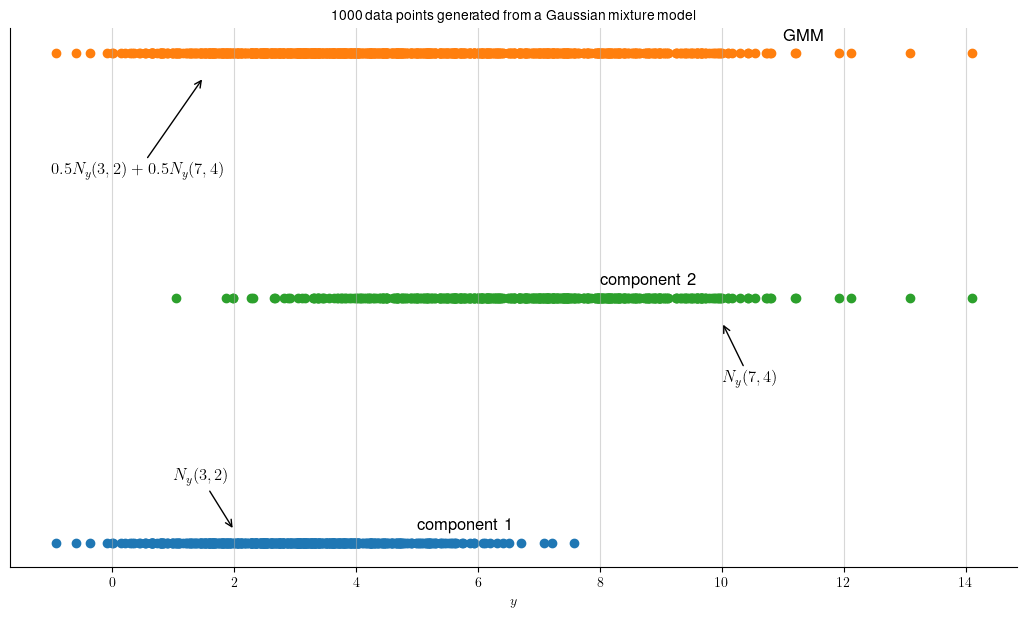

In [100]:
K = 2 #two Gaussian components
mu1 = 3 #setting the two means apart from each other
mu2 = 7
sigma1 = 2 #variances for the two Gaussian components
sigma2 = 4

pi_1 = 1/2
pi_2 = 1 - pi_1

N = 1000

X = np.zeros(N)
X1 = np.zeros(N) # vectors to save the samples of the two Gaussian components
X2 = np.zeros(N)
res1 = np.zeros(N)
res2 = np.zeros(N)

N1 = 0 # counts how many samples from first Gaussian component
N2 = 0 # counter for samples from second Gaussian component

for n in range(N):
    x = np.random.rand() #random number between 0 and 1
    if x <= pi_1: #generate data point from first Gaussian distribution
        k = 1
        x_bar = mu1
        SR = np.sqrt(sigma1)
        res1[N1] = k #save which component
        X1[N1] = x_bar + SR*np.random.randn() # generate Gaussian sample-
        X[n] = X1[N1] #save it
        N1 += 1
    else: #generate data point from second Gaussian distribution
        k = 2
        x_bar = mu2
        SR = np.sqrt(sigma2)
        res2[N2] = k #sabe which component
        X2[N2] = x_bar + SR*np.random.randn() # generate Gaussian sample
        X[n] = X2[N2]
        N2 += 1

#Plot data
YA = np.zeros(N1)
YB = 2*np.ones(N2)
YC = 4*np.ones(N)

XA = X1[:N1]
XB = X2[:N2]

#figure 1 (scatter plots)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(XA, YA, color="tab:blue")
ax.scatter(XB, YB, color="tab:green")
ax.scatter(X, YC, color="tab:orange")
ax.set_xlabel("$y$", fontsize=10)
ax.set_title("1000 data points generated from a Gaussian mixture model", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

ax.annotate("$0.5N_y(3, 2) + 0.5N_y(7, 4)$", xy=(1.5, 3.8), xytext=(-1, 3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("$N_y(7, 4)$", xy=(10, 1.8), xytext=(10, 1.3), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("$N_y(3, 2)$", xy=(2, 0.1), xytext=(1, 0.5), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=12, fontweight='bold')
ax.annotate("GMM", xy=(11, 4.1), fontsize=12, fontweight='bold')
ax.annotate("component 2", xy=(8, 2.1), fontsize=12, fontweight='bold')
ax.annotate("component 1", xy=(5, .1), fontsize=12, fontweight='bold')
plt.yticks([])

plt.show()

**Figure $32.1$** The lowest line shows the location of the scattered samples that are generated according to the first Gaussian component ${\cal N}(3,2)$. The middle line shows the location of the scattered samples that are generated according to the second  Gaussian component ${\cal N}(7,4)$. The top line shows the locations of all observations combined generated by the Gaussian mixture model defined by (32.3).

524 476 1000
3 7 2 4
6.785 2.908 4.0 1.722


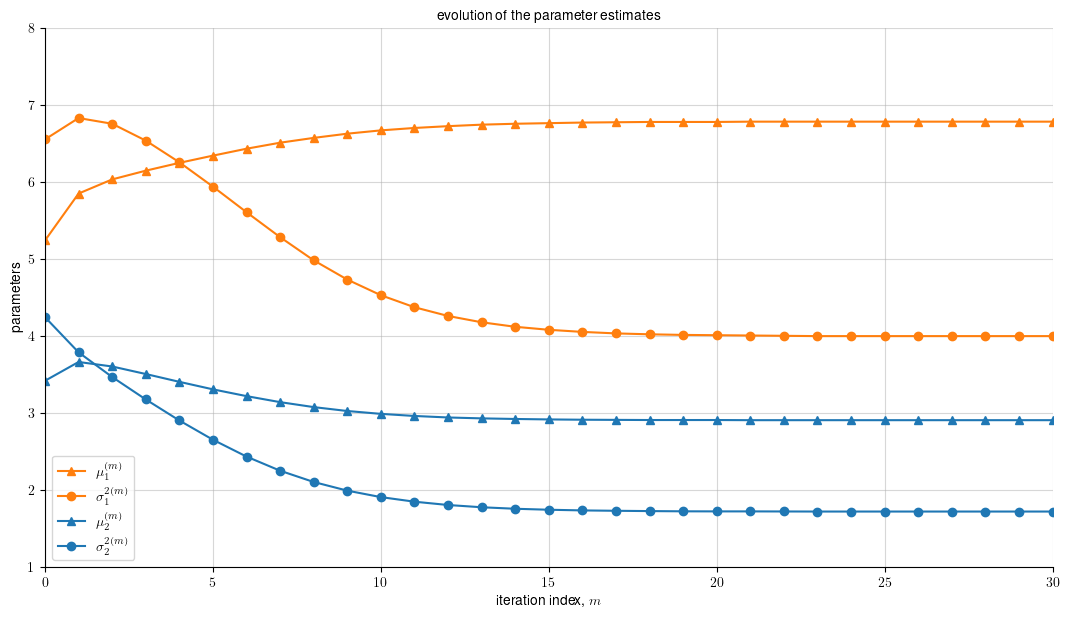

In [101]:
mu_hat = np.round(2*np.random.rand(2)).astype(np.float16) #initial condition for mean vector estimate
sigma_hat = (1 + np.round(2*np.random.rand(2))).astype(np.float16) #initial condition for variance estimates

mu_hat =np.array([1, 0]).astype(np.float16) #Forcing it to look like the book
sigma_hat = np.array([3, 3]).astype(np.float16) #Forcing it to look like the book

M = 50 # number of EM iterations
N_hat = np.zeros(2)
par = np.zeros((M, 4))
r_hat = np.zeros((K, N))

for m in range(M):
    #E-step
    for k in range(K): #iterarion over components
        for n in range(N): 
            y = X[n] #sample from the mixture distribution generated earlier
            a = scalar_gaussian(y, mu_hat[k], sigma_hat[k])
            d = scalar_gaussian(y, mu_hat[0], sigma_hat[0]) + scalar_gaussian(y, mu_hat[1], sigma_hat[1])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k, :].sum()
    
    #M-step
    z1 = r_hat[0, :]@X.T
    z2 = r_hat[1, :]@X.T
    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]

    Xcen1 = X - mu_hat[0]*np.ones(N)
    Xcen2 = X - mu_hat[1]*np.ones(N)
    S1 = Xcen1**2
    S2 = Xcen2**2
    r1 = r_hat[0, :]@S1.T
    r2 = r_hat[1, :]@S2.T
    sigma_hat[0] = r1/N_hat[0]
    sigma_hat[1] = r2/N_hat[1]

    par[m, :] = np.array([
        mu_hat[0], mu_hat[1], sigma_hat[0], sigma_hat[1]
    ])

print(N1, N2, N)
print(mu1, mu2, sigma1, sigma2)
print(mu_hat[0], mu_hat[1], sigma_hat[0], sigma_hat[1])

#figure 2 (evolution of the EM estimates)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.plot(np.arange(0, M, 1), par[:, 0], color="tab:orange", marker="^", label="$\mu_{1}^{(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 2], color="tab:orange", marker="o", label="$\sigma_{1}^{2(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 1], color="tab:blue", marker="^", label="$\mu_{2}^{(m)}$")
ax.plot(np.arange(0, M, 1), par[:, 3], color="tab:blue", marker="o", label="$\sigma_{2}^{2(m)}$")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("parameters", fontsize=10)
ax.set_title("evolution of the parameter estimates", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.yticks(np.arange(1, 9, 1))
plt.xticks(np.arange(0, 35, 5))
ax.set_xlim([0, 30])

plt.legend()

plt.show()

**Figure $32.2$** Evolution of the iterates $\{\mu_1^{(m)},\mu_2^{(m)},\sigma_1^{2(m)},\sigma_2^{2(m)}\}$ towards their steady-state values for increasing values of the iteration index, $m$.

## Example 32.3 (Gaussian mixture models)

Model (32.3) is a special case of a larger family of models known as {\em Gaussian mixture models}. In these models, the pdf of the observation variable $y$ is modeled as a convex combination of individual Gaussian pdfs; the combination coefficients are $\{{1\over 2},{1\over 2}\}$ in (32.3), which involves only the mixture of two Gaussian distributions. More broadly, there can be a larger number of mixture components and the combination coefficients do not need to be equal. We can also consider models where the  elementary mixture components are not necessarily Gaussian. The following example motivates GMMs.

Consider an example involving the grade distribution in two offerings of a course on Calculus. All grades are in the range $[0,100]$. Assume that the distribution of the grades in the first offering is well approximated by a Gaussian distribution with mean $\mu_1=45$ and variance $\sigma_1^2=30$, which we denote by

$
f_{1}(y)=\frac{1}{\sqrt{2\pi\sigma_1^2}}\;e^{-\frac{1}{2\sigma_1^2}(y-\mu_1)^{2}}\overset{\Delta}{=} {\cal N}_{y}(\mu_1,\sigma_1^2)\;=\;{\cal N}_1
$

Here, the random variable $y$ refers to the grade. Likewise, assume the distribution of the grades in the second course is well approximated by a Gaussian distribution with mean $\mu_2=65$ and variance $\sigma_2^2=15$, i.e.,

$
f_{2}(y)=\frac{1}{\sqrt{2\pi\sigma_2^2}}\;e^{-\frac{1}{2\sigma_2^2}(y-\mu_2)^{2}} \overset{\Delta}{=}{\cal N}_{y}(\mu_2,\sigma_2^2)\;=\;{\cal N}_2
$

One useful question is to inquire about the form of the grade distribution for both offerings combined. We can determine this distribution as follows. Assume that the first course offering had $40$ students while the second course offering had $60$ students. If we select one grade at random from both courses, it has likelihood  $\pi_1=0.4$ of belonging to the first course and $\pi_2=0.6$ of belonging to the second course. Therefore, the overall distribution of the grade variable $y$ can be described by combining  the individual distributions in a weighted manner as follows:

$
f_{y}(y)=\sum_{k=1}^{2} \mathbb{P}\left(y\sim {\cal N}_k\right) f_{y|{\cal N}_k}(y\,|\,y\sim {\cal N}_k) =\pi_1 f_1(y)\;+\;\pi_2f_2(y)
$

Observe that we are using the subscripts $1$ and $2$ for the mixture components, $f_1(y)$ and $f_2(y)$, while we continue to use the subscript $y$ for the aggregate distribution, $f_{y}(y)$. Figure~\ref{figGMM.label} shows the individual distributions on the left and the resulting mixture distribution on the right.  Observe that the resulting distribution is not Gaussian. It is nevertheless well modeled by the combination of two Gaussian models.

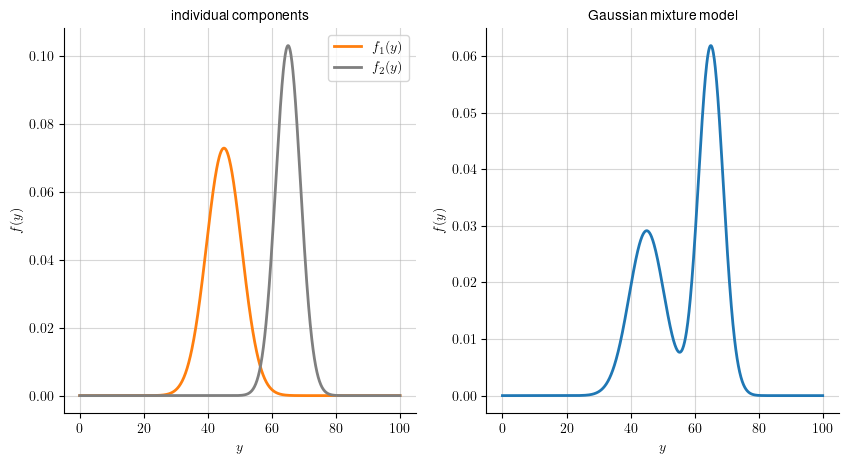

In [102]:
mu1 = 45
sigma1 = 30
mu2 = 65
sigma2 = 15
a1 = 1/(np.sqrt(2*np.pi*sigma1)) #scaling factors in Gaussian distributions
b1 = 0.5/sigma1
a2 = 1/(np.sqrt(2*np.pi*sigma2)) 
b2 = 0.5/sigma2
p = 0.4

x = np.arange(0, 100, 0.1)
f1 = a1*np.exp(-b1*(x-mu1)**2) # first Gaussian pdf
f2 = a2*np.exp(-b2*(x-mu2)**2) # second Gaussian pdf
f = p*f1 + (1-p)*f2 # mixture Gausssian

#figure 3 (Gaussian mixture model)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10,5
fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(x, f1, color="tab:orange", label="$f_{1}(y)$", linewidth=2)
ax.plot(x, f2, color="tab:gray", label="$f_{2}(y)$", linewidth=2)
ax.set_xlabel("$y$", fontsize=10)
ax.set_ylabel("$f(y)$", fontsize=10)
ax.set_title("individual components", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.legend()

ax = fig.add_subplot(122)
ax.plot(x, f, color="tab:blue", label="$f_{1}(y)$", linewidth=2)
ax.set_xlabel("$y$", fontsize=10)
ax.set_ylabel("$f(y)$", fontsize=10)
ax.set_title("Gaussian mixture model", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig("figs/fig-3.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure $31.1$** ($\textit{Left}$) Two individual Gaussian distributions. ($\textit{Right}$) Gaussian mixture distribution obtained by combining the individual distributions with weights $\pi_1=0.4$ and $\pi_2=0.6$, respectively.

## Example 32.5 (Clustering)

We illustrate the Gaussian mixture model graphically by considering $K=3$ two-dimensional (i.e., $P=2$) Gaussian components in Fig. 32.4. The figure shows a scatter diagram consisting of $N=1500$ points selected from their respective Gaussian distributions according to the probabilities:

$\pi_1=0.2515,\;\;\;\;\pi_2=0.5236,\;\;\;\;\pi_3=0.2249$

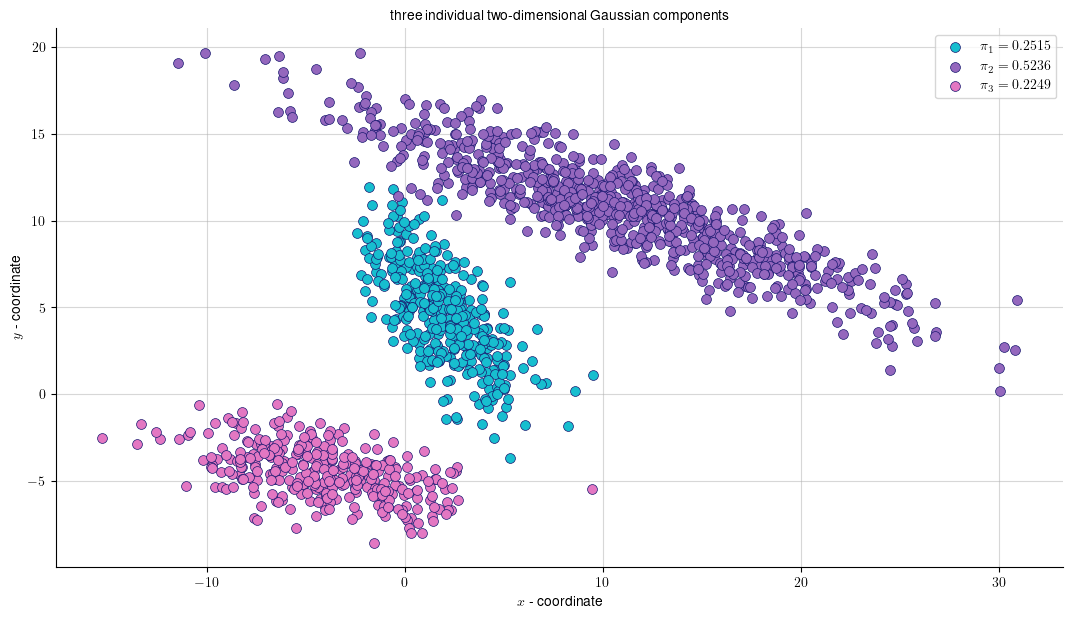

In [103]:
K = 3 # 3 Gaussian components
p = 2

mu1 = np.array([2.0187, 4.3124])
mu2 = np.array([10.5560, 10.7832])
mu3 = np.array([-4.3228, -4.5155])

R1 = np.array([
    [4, -4],
    [-4, 8]
])

R2 = np.array([
    [45, -18],
    [-18, 9]
])

R3 = np.array([
    [10, -2],
    [-2, 2]
])

pi_1 = 0.2515
pi_2 = 0.5236
pi_3 = 1-(pi_1+pi_2)

N = 1500
N1 = int(N*pi_1)
N2 = int(N*pi_2)
N3 = int(N*pi_3)

X1 = np.random.multivariate_normal(mean=mu1, cov=R1, size=N1)
X2 = np.random.multivariate_normal(mean=mu2, cov=R2, size=N2)
X3 = np.random.multivariate_normal(mean=mu3, cov=R3, size=N3)


#figure 2 (evolution of the EM estimates)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13,7
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(X1[:, 0], X1[:, 1], label="$\pi_1 = 0.2515$", color="tab:cyan", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X2[:, 0], X2[:, 1], label="$\pi_2 = 0.5236$", color="tab:purple", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X3[:, 0], X3[:, 1], label="$\pi_3 = 0.2249$", color="tab:pink", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.set_xlabel("$x$ - coordinate", fontsize=10)
ax.set_ylabel("$y$ - coordinate", fontsize=10)
ax.set_title("three individual two-dimensional Gaussian components", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)

plt.legend()

plt.show()



**Figure $32.4$** Scatter diagram for $N=1500$ points generated from three individual Gaussian components with mean vectors and covariance matrices given by (32.48a)--(32.48b). For each sample point, the corresponding Gaussian component is selected randomly according to the probabilities (32.47).

The mean vectors and covariance matrices of the mixture components for this example are given by:

$
\mu_1 = 
\begin{bmatrix}
2.0187 \\ 4.3124
\end{bmatrix} \;\;\;
\mu_2 = 
\begin{bmatrix}
10.5560 \\ 10.7832
\end{bmatrix} \;\;\;
\mu_3 = 
\begin{bmatrix}
-4.3228 \\ -4.5155
\end{bmatrix}
$

$
R_1 = 
\begin{bmatrix}
4 & -4 \\ -4 & 8
\end{bmatrix} \;\;\;
R_2 = 
\begin{bmatrix}
45 & -18 \\ -18 & 9
\end{bmatrix} \;\;\;
R_3 = 
\begin{bmatrix}
10 & -2 \\ -2 & 2
\end{bmatrix} \;\;\;
$

Observe how the sample points in the figure appear clustered in three groups. This observation motivates two useful questions. Assume we are given the sample points $\{y_n,\;n=1,2,\ldots,N\}$ shown in the figure. Then, the following questions become pertinent:

$\textbf{(a) (Modeling).}$ Is it possible to devise a procedure to estimate the parameters $\{\mu_k,R_k\}$ for the individual components of the underlying GMM?
 
$\textbf{(b) (Clustering).}$ If a new datum $y$ arrives,  is it possible to determine which Gaussian component is more likely to have generated it?

     
The answer to the second question can be obtained by employing expression (32.45) to determine the responsibility score\is{responsibility score} for each mixture component and to select the component that is most likely to have generated the observation. This procedure provides one useful way to solve clustering problems. We will be discussing other clustering techniques in future chapters. Clustering is an important form of $\textit{unsupervised}$ learning; it allows us to group the data $y_n$ into their most likely components or classes.
 The answer to the first question can be obtained by applying the EM  algorithm, which we discuss next.

## Example 32.6 (Numerical example for GMM)

We apply the EM recursions (32.67) to a GMM  consisting of $K=3$ two-dimensional (i.e., $P=2$) Gaussian components. Figure 32.6 shows the scatter diagram for $N=1500$ sample points generated from their respective Gaussian distributions according to the probabilities:

$
\pi_1=\frac{1}{3},\;\;\;\;\pi_2=\frac{1}{4},\;\;\;\;\pi_3=\frac{5}{12}
$

The mean vectors and covariance matrices of the mixture components for this example are given by:

$
\mu_1 = 
\begin{bmatrix}
2 \\ 3
\end{bmatrix} \;\;\;
\mu_2 = 
\begin{bmatrix}
10 \\ 10
\end{bmatrix} \;\;\;
\mu_3 = 
\begin{bmatrix}
30 \\ 15
\end{bmatrix}
$

$
R_1 = 
\begin{bmatrix}
4 & -4 \\ -4 & 8
\end{bmatrix} \;\;\;
R_2 = 
\begin{bmatrix}
45 & -18 \\ -18 & 9
\end{bmatrix} \;\;\;
R_3 = 
\begin{bmatrix}
10 & -2 \\ -2 & 2
\end{bmatrix} \;\;\;
$

We apply the EM recursions (32.67) for $M=150$ iterations and arrive at the estimates below; the figure also shows the level curves for the estimated Gaussian distributions:

$
\widehat{\mu_1} = 
\begin{bmatrix}
2.0515 \\ 2.9422
\end{bmatrix} \;\;\;
\widehat{\mu_2} = 
\begin{bmatrix}
10.1401 \\ 9.94994
\end{bmatrix} \;\;\;
\widehat{\mu_3} = 
\begin{bmatrix}
29.9229 \\ 14.9785
\end{bmatrix}
$

$
\widehat{R_1} = 
\begin{bmatrix}
4.0944 & -4.0233 \\ -4.0233 & 7.4445
\end{bmatrix} \;\;\;
\widehat{R_2} = 
\begin{bmatrix}
45.9752 & -18.2610 \\ -18.2610 & 9.1126
\end{bmatrix} \;\;\;
\widehat{R_3} = 
\begin{bmatrix}
9.9815 & -2.0386 \\ -2.0386 & 1.9939
\end{bmatrix} \;\;\;
$


In [105]:
K = 3
p = 2

mu1 = [2, 3]
mu2 = [10, 10]
mu3 = [30, 14]

R1 = [[4, -4], [-4, 8]]
R2 = [[45, -18], [-18, 9]]
R3 = [[10, -2], [-2, 2]]

pi_1 = 1/3
pi_2 = 1/4
pi_3 = 5/12

N = 1500
N1 = int(N*pi_1)
N2 = int(N*pi_2)
N3 = int(N*pi_3)

X1 = np.random.multivariate_normal(mean=mu1, cov=R1, size=N1)
X2 = np.random.multivariate_normal(mean=mu2, cov=R2, size=N2)
X3 = np.random.multivariate_normal(mean=mu3, cov=R3, size=N3)

X = np.concatenate([X1, X2, X3])
np.random.shuffle(X) #concatenating samples from all 3 Gaussian components and shuffling its contents


# Running EM

mu_hat_1 = np.zeros((1,p))
mu_hat_2 = np.zeros((1,p))
mu_hat_3 = np.zeros((1,p))

mu_hat = [mu_hat_1, mu_hat_2, mu_hat_3]

R_hat_1 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates
R_hat_2 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates
R_hat_3 = np.eye(p) + np.round(np.random.rand(p, p)) #variance estimates

R_hat = [R_hat_1, R_hat_2, R_hat_3]

pi_hat_1 = pi_hat_2 = pi_hat_3 = 1/3

pi_hat = [pi_hat_1, pi_hat_2, pi_hat_3]

r_hat = np.zeros((K, N))

M = 150 # number of iterations
N_hat = np.zeros(K)

for m in range(M):
    #E-step
    for k in range(K):
        mu_hat_k = mu_hat[k]
        R_hat_k = R_hat[k]
        pi_hat_k = pi_hat[k]

        for n in range(N):
            y = X[n]
            a = pi_hat_k*vector_gaussian(y, mu_hat_k, R_hat_k)
            d = pi_hat[0]*vector_gaussian(y, mu_hat[0], R_hat[0])
            d += pi_hat[1]*vector_gaussian(y, mu_hat[1], R_hat[1])
            d += pi_hat[2]*vector_gaussian(y, mu_hat[2], R_hat[2])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k].sum()

    #M-step
    z1 = r_hat[0]@X
    z2 = r_hat[1]@X
    z3 = r_hat[2]@X

    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]
    mu_hat[2] = z3/N_hat[2]

    Xcen1 = X - mu_hat[0]
    Xcen2 = X - mu_hat[1]
    Xcen3 = X - mu_hat[2]

    S1 = np.zeros((p, p))
    S2 = np.zeros((p, p))
    S3 = np.zeros((p, p))
    for n in range(N):
        S1 += r_hat[0, n]*Xcen1[n].reshape(-1, 1)@Xcen1[n].reshape(-1, 1).T
        S2 += r_hat[1, n]*Xcen2[n].reshape(-1, 1)@Xcen2[n].reshape(-1, 1).T
        S3 += r_hat[2, n]*Xcen3[n].reshape(-1, 1)@Xcen3[n].reshape(-1, 1).T

    R_hat[0] = S1/N_hat[0]
    R_hat[1] = S2/N_hat[1]
    R_hat[2] = S3/N_hat[2]

    pi_hat[0] = N_hat[0]/N
    pi_hat[1] = N_hat[1]/N
    pi_hat[2] = N_hat[2]/N

    epsilon = 0.0001
    if m <= p:
        R_hat[0] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[1] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[2] += epsilon*np.eye(2) #add small pertubation to avoid singular R's

print(mu1, mu_hat[0], mu2, mu_hat[1], mu3, mu_hat[2])
print(R1, R_hat[0], R2, R_hat[1], R3, R_hat[2])

[2, 3] [2.13329205 2.92234935] [10, 10] [10.89491406  9.58477946] [30, 14] [29.9685515  14.02046601]
[[4, -4], [-4, 8]] [[ 3.89472061 -4.01421889]
 [-4.01421889  8.07156982]] [[45, -18], [-18, 9]] [[ 41.52582118 -16.78996259]
 [-16.78996259   8.45176053]] [[10, -2], [-2, 2]] [[10.20922186 -1.8304446 ]
 [-1.8304446   2.02374593]]


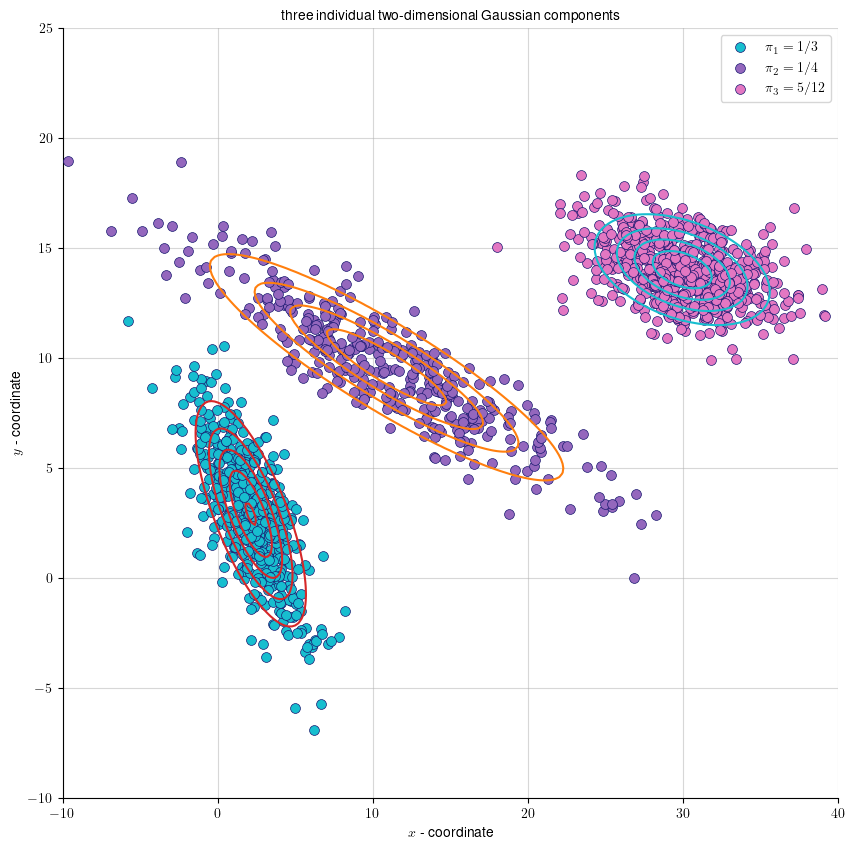

In [107]:
[T1, H1] = np.meshgrid(np.arange(-10, 40, 0.2), np.arange(-10, 40, 0.2))
[T2, H2] = np.meshgrid(np.arange(-10, 40, 0.2), np.arange(-10, 40, 0.2))
[T3, H3] = np.meshgrid(np.arange(-10, 40, 0.2), np.arange(-10, 40, 0.2))

pdf1 = stats.multivariate_normal(mu_hat[0], R_hat[0]).pdf(np.dstack((T1, H1))) 
pdf2 = stats.multivariate_normal(mu_hat[1], R_hat[1]).pdf(np.dstack((T2, H2)))
pdf3 = stats.multivariate_normal(mu_hat[2], R_hat[2]).pdf(np.dstack((T3, H3)))


#figure 6 (clustering)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=10, 10
fig = plt.figure()

ax = fig.add_subplot(111)
ax.scatter(X1[:, 0], X1[:, 1], label="$\pi_1 = 1/3$", color="tab:cyan", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X2[:, 0], X2[:, 1], label="$\pi_2 = 1/4$", color="tab:purple", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.scatter(X3[:, 0], X3[:, 1], label="$\pi_3 = 5/12$", color="tab:pink", edgecolor="midnightblue", linewidth=0.5, s=50, zorder=3)
ax.contour(T1, H1, pdf1, zorder=3, levels=5, colors="tab:red", linewidths=1.5)
ax.contour(T2, H2, pdf2, zorder=3, levels=5, colors="tab:orange", linewidths=1.5)
ax.contour(T3, H3, pdf3, zorder=3, levels=5, colors="tab:cyan", linewidths=1.5)

ax.set_xlabel("$x$ - coordinate", fontsize=10)
ax.set_ylabel("$y$ - coordinate", fontsize=10)
ax.set_title("three individual two-dimensional Gaussian components", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylim([-10, 25])
ax.set_xlim([-10, 40])

plt.legend()

plt.show()

**Figure $32.6$** Scatter diagram for $N=1500$ points generated from three individual Gaussian components with mean vectors and covariance matrices given by (32.77a)--(32.77b). For each sample point, the corresponding Gaussian component is selected randomly according to the probabilities (32.76).

## Example 32.7 (Fitting a GMM onto the iris dataset)

Figure 32.7 shows scatter diagrams for measurements of petal length and petal width in centimeters for three types of iris flowers (setosa, versicolor, and virginica) from the iris dataset. The flowers were shown earlier in Fig. 27.5.

For each flower, we collect the petal length and petal width into a $2\times 1$ vector:

$
y_n = 
\begin{bmatrix}
\textnormal{petal length} \\ \textnormal{petal width}
\end{bmatrix} \;\;\; (\textnormal{measured in cm})
$

There are 50 measurements for each flower type with a total of $N=150$ measurements. The top leftmost plot in  Fig.~\ref{llaksfigGM;;laslM-DD.label} shows a scatter diagram for all $N=150$ petal length $\times$ petal width observations for the three flower types. We are using the same color to represent all scatter points in the diagram in order to indicate the fact that the EM procedure does not know beforehand that these points arise from three underlying distributions.  In the top plot on the right, we repeat the same scatter diagram but now color the scatter points and also use circle, square, and diamond markers in order to specify which measurements arise from which flower type. This grouping represents the underlying truth and is  based on the information we already know about the dataset and is not the result of any automatic clustering procedure. It is clear from this latter scatter diagram that the data from the versicolor and virginica flowers overlap with each other, which is going to interfere with the procedure of fitting a GMM onto the data.

In [29]:
data = scipy.io.loadmat("data/iris_data.mat") #loaded into variable data
Ntotal = 150 #total number of data points
features = data["A"][:Ntotal, :4] #each row is a feature vector with 4 attributes (petal length, petal width, 
                                    # sepal length, sepal width)
labels = data["A"][:Ntotal, 4] #entry is 0=setosa, 1=versicolor, 2=virginica

#separating features by class

features_0 = features[labels==0][:, :2]
features_1 = features[labels==1][:, :2]
features_2 = features[labels==2][:, :2]

counter_0 = features_0.shape[0]
counter_1 = features_1.shape[0]
counter_2 = features_2.shape[0]

L = max(features_0.shape)

mean0 = features_0.mean(axis=0)
XR0 = np.diag(features_0.std(axis=0))

mean1 = features_1.mean(axis=0)
XR1 = np.diag(features_1.std(axis=0))

mean2 = features_2.mean(axis=0)
XR2 = np.diag(features_2.std(axis=0))

K = 3 #Gaussian components
p = 2

mu1 = mean0.reshape(-1, 1).T
mu2 = mean1.reshape(-1, 1).T
mu3 = mean2.reshape(-1, 1).T

SR1 = XR0
SR2 = XR1
SR3 = XR2

pi_1 = 1/3
pi_2 = 1/3
pi_3 = 1/3

N = Ntotal
X = np.concatenate([features_0, features_1, features_2])

R1 = SR1@SR1.T
R2 = SR2@SR2.T
R3 = SR3@SR3.T

# Running EM

mu_hat_1 = mean0.reshape(-1, 1).T
mu_hat_2 = mean1.reshape(-1, 1).T
mu_hat_3 = mean2.reshape(-1, 1).T

mu_hat = [mu_hat_1, mu_hat_2, mu_hat_3]

R_hat_1 = R1 #variance estimates
R_hat_2 = R2 #variance estimates
R_hat_3 = R3 #variance estimates

R_hat = [R_hat_1, R_hat_2, R_hat_3]

pi_hat_1 = 1/3
pi_hat_2 = 1/3
pi_hat_3 = 1/3

pi_hat = [pi_hat_1, pi_hat_2, pi_hat_3]

r_hat = np.zeros((K, N))

M = 150 # number of iterations
N_hat = np.zeros(K)

for m in range(M):
    #E-step
    for k in range(K):
        mu_hat_k = mu_hat[k]
        R_hat_k = R_hat[k]
        pi_hat_k = pi_hat[k]

        for n in range(N):
            y = X[n]
            a = pi_hat_k*vector_gaussian(y, mu_hat_k, R_hat_k)
            d = pi_hat[0]*vector_gaussian(y, mu_hat[0], R_hat[0])
            d += pi_hat[1]*vector_gaussian(y, mu_hat[1], R_hat[1])
            d += pi_hat[2]*vector_gaussian(y, mu_hat[2], R_hat[2])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k].sum()

    #M-step
    z1 = r_hat[0]@X
    z2 = r_hat[1]@X
    z3 = r_hat[2]@X

    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]
    mu_hat[2] = z3/N_hat[2]

    Xcen1 = X - mu_hat[0]
    Xcen2 = X - mu_hat[1]
    Xcen3 = X - mu_hat[2]

    S1 = np.zeros((p, p))
    S2 = np.zeros((p, p))
    S3 = np.zeros((p, p))
    for n in range(N):
        S1 += r_hat[0, n]*Xcen1[n].reshape(-1, 1)@Xcen1[n].reshape(-1, 1).T
        S2 += r_hat[1, n]*Xcen2[n].reshape(-1, 1)@Xcen2[n].reshape(-1, 1).T
        S3 += r_hat[2, n]*Xcen3[n].reshape(-1, 1)@Xcen3[n].reshape(-1, 1).T

    R_hat[0] = S1/N_hat[0]
    R_hat[1] = S2/N_hat[1]
    R_hat[2] = S3/N_hat[2]

    pi_hat[0] = N_hat[0]/N
    pi_hat[1] = N_hat[1]/N
    pi_hat[2] = N_hat[2]/N

    epsilon = 0.0001
    if m <= p:
        R_hat[0] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[1] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[2] += epsilon*np.eye(2) #add small pertubation to avoid singular R's

print(mu1, mu_hat[0], mu2, mu_hat[1], mu3, mu_hat[2])
print(R1, R_hat[0], R2, R_hat[1], R3, R_hat[2])

ind = r_hat.argmax(axis=0)
lkd = r_hat.argmax(axis=1)

class_0_X = X[ind==0]
class_1_X = X[ind==1]
class_2_X = X[ind==2]


[[5.006 3.418]] [5.01588049 3.44410674] [[5.936 2.77 ]] [6.10451322 2.87791873] [[6.588 2.974]] [6.34724693 2.86199887]
[[0.121764 0.      ]
 [0.       0.142276]] [[0.11954788 0.08957516]
 [0.08957516 0.12054335]] [[0.261104 0.      ]
 [0.       0.0965  ]] [[0.48313934 0.21864444]
 [0.21864444 0.12996294]] [[0.396256 0.      ]
 [0.       0.101924]] [[0.43047131 0.04660431]
 [0.04660431 0.09636149]]


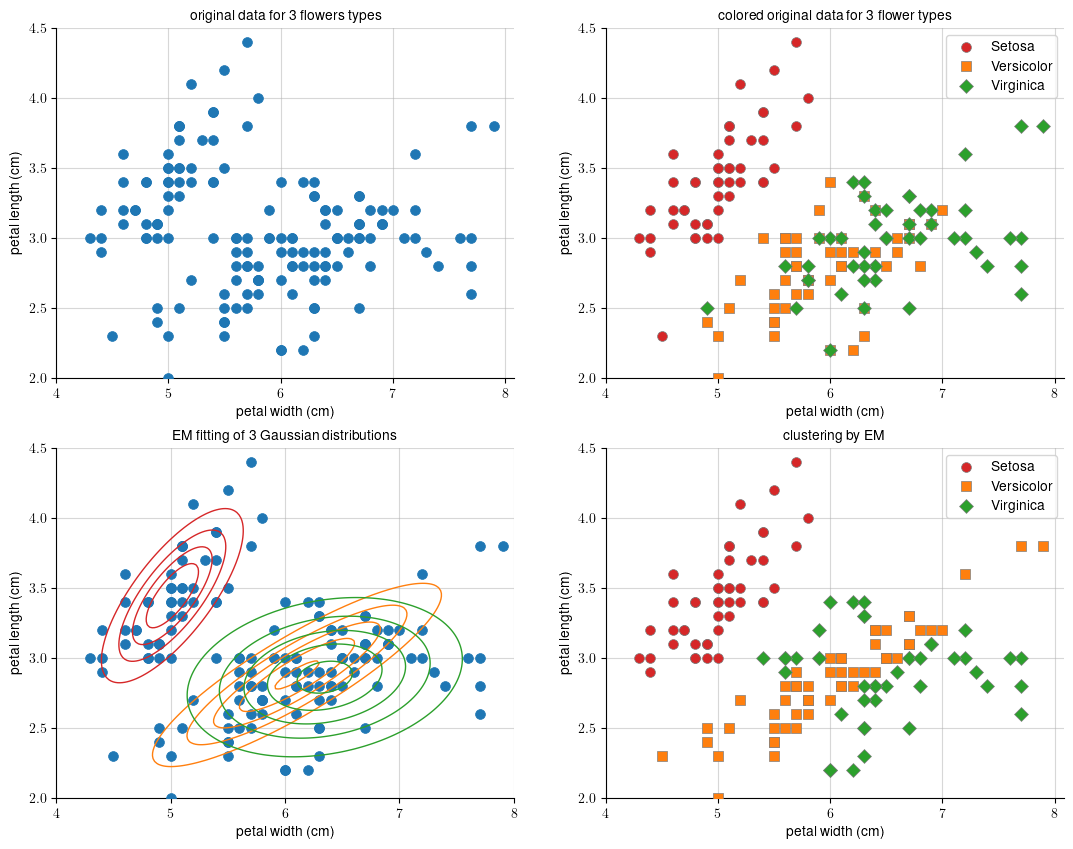

In [186]:
[T1, H1] = np.meshgrid(np.arange(4, 8, 0.02), np.arange(2, 4.5, 0.02))
[T2, H2] = np.meshgrid(np.arange(4, 8, 0.02), np.arange(2, 4.5, 0.02))
[T3, H3] = np.meshgrid(np.arange(4, 8, 0.02), np.arange(2, 4.5, 0.02))

pdf1 = stats.multivariate_normal(mu_hat[0], R_hat[0]).pdf(np.dstack((T1, H1))) 
pdf2 = stats.multivariate_normal(mu_hat[1], R_hat[1]).pdf(np.dstack((T2, H2)))
pdf3 = stats.multivariate_normal(mu_hat[2], R_hat[2]).pdf(np.dstack((T3, H3)))


#figure 6 (clustering)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 10
fig = plt.figure()

ax = fig.add_subplot(221)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_2[:, 0], features_2[:, 1], label="Virginica", color="tab:blue", linewidth=0.5, s=50, zorder=3)

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("original data for 3 flowers types", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])

ax = fig.add_subplot(222)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:red", linewidth=0.5, s=50, zorder=3, marker="o", edgecolors="tab:gray")
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:orange", linewidth=0.5, s=50, zorder=3, marker="s", edgecolors="tab:gray")
ax.scatter(features_2[:, 0], features_2[:, 1], label="Virginica", color="tab:green", linewidth=0.5, s=50, zorder=3, marker="D", edgecolors="tab:gray")

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("colored original data for 3 flower types", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])
plt.legend()

ax = fig.add_subplot(223)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_2[:, 0], features_2[:, 1], label="Virginica", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.contour(T1, H1, pdf1, zorder=3, levels=5, colors="tab:red", linewidths=1)
ax.contour(T2, H2, pdf2, zorder=3, levels=5, colors="tab:orange", linewidths=1)
ax.contour(T3, H3, pdf3, zorder=3, levels=5, colors="tab:green", linewidths=1)

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("EM fitting of 3 Gaussian distributions", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])

ax = fig.add_subplot(224)
ax.scatter(class_0_X[:, 0], class_0_X[:, 1], label="Setosa", color="tab:red", linewidth=0.5, s=50, zorder=3, marker="o", edgecolors="tab:gray")
ax.scatter(class_1_X[:, 0], class_1_X[:, 1], label="Versicolor", color="tab:orange", linewidth=0.5, s=50, zorder=3, marker="s", edgecolors="tab:gray")
ax.scatter(class_2_X[:, 0], class_2_X[:, 1], label="Virginica", color="tab:green", linewidth=0.5, s=50, zorder=3, marker="D", edgecolors="tab:gray")

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("clustering by EM", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])
plt.legend()

plt.show()

**Figure 32.7** ($\textit{Top left}$) Scatter diagram for $N=150$ petal length $\times$ petal width measurements for three types of iris flowers: setosa, versicolor, and virginica. ($\textit{Top right}$) The same scatter diagram albeit with color and marker groupings to
specify which measurements arise from which flower type. This grouping is based on the information we have and is not the result of any automatic clustering procedure. ($\textit{Bottom left}$) Gaussian level sets obtained from running $M=150$ iterations of the EM procedure (32.67). ($\textit{Bottom right}$)  Clustering result from the EM procedure where each data point is assigned to the most likely Gaussian component. It is seen in this example, by comparing the two plots on the right (showing actual clustering versus predicted clustering) that the data from the versicolor and virginica flowers overlap and cause degradation in the clustering result. 

We run the EM procedure for $M=150$ iterations assuming $K=3$ Gaussian mixture models. The result is the level curves shown in the bottom left plot in the figure. The Gaussian components are found to have the following means and covariance matrices:

$
\widehat{\mu_1} = 
\begin{bmatrix}
5.0159 \\ 3.4441
\end{bmatrix} \;\;\;
\widehat{\mu_2} = 
\begin{bmatrix}
6.1045 \\ 2.8779
\end{bmatrix} \;\;\;
\widehat{\mu_3} = 
\begin{bmatrix}
6.3471 \\ 2.8620
\end{bmatrix}
$

$
\widehat{R_1} = 
\begin{bmatrix}
0.1195 & 0.0896 \\ 0.0896 & 0.1205
\end{bmatrix} \;\;\;
\widehat{R_2} = 
\begin{bmatrix}
0.4832 & 0.2187 \\ 0.2187 & 0.1300
\end{bmatrix} \;\;\;
\widehat{R_3} = 
\begin{bmatrix}
0.4304 & 0.0466 \\ 0.0466 & 0.0964
\end{bmatrix} \;\;\;
$

The mixing probabilities are also estimated to be

$
\widehat{\pi}_1=0.3212,\;\;\;\widehat{\pi}_2=0.3138,\;\;\;
\widehat{\pi}_3=0.3649
$

The EM procedure further provides for each observation vector $y_n$ a measure of the likelihood that it belongs to one of the Gaussian components through the responsibility measures $\widehat{r}(k,y_n)$. We use these measures to determine the most likely component for each $y_n$ and construct the clustering scatter diagram shown in the bottom right plot. Comparing this plot with the actual one shown above it, it is clear that the data from the versicolor and virginica flowers interfere with each other and cause errors in the clustering results with, for example, some data originating from the virginica dataset being declared as originating from the versicolor dataset.

In [30]:
# repeating the procedure using 2 classes only

K = 2

mu1 = mean0.reshape(-1, 1).T
mu2 = mean1.reshape(-1, 1).T

SR1 = XR0
SR2 = XR1

pi_1 = 1/2
pi_2 = 1/2

X = np.concatenate([features_0, features_1])
N = max(X.shape)

R1 = SR1@SR1.T
R2 = SR2@SR2.T

# Running EM

mu_hat_1 = mean0.reshape(-1, 1).T
mu_hat_2 = mean1.reshape(-1, 1).T

mu_hat = [mu_hat_1, mu_hat_2]

R_hat_1 = R1 #variance estimates
R_hat_2 = R2 #variance estimates

R_hat = [R_hat_1, R_hat_2]

pi_hat_1 = 1/2
pi_hat_2 = 1/2

pi_hat = [pi_hat_1, pi_hat_2]

r_hat = np.zeros((K, N))

M = 150 # number of iterations
N_hat = np.zeros(K)

for m in range(M):
    #E-step
    for k in range(K):
        mu_hat_k = mu_hat[k]
        R_hat_k = R_hat[k]
        pi_hat_k = pi_hat[k]

        for n in range(N):
            y = X[n]
            a = pi_hat_k*vector_gaussian(y, mu_hat_k, R_hat_k)
            d = pi_hat[0]*vector_gaussian(y, mu_hat[0], R_hat[0])
            d += pi_hat[1]*vector_gaussian(y, mu_hat[1], R_hat[1])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k].sum()

    #M-step
    z1 = r_hat[0]@X
    z2 = r_hat[1]@X

    mu_hat[0] = z1/N_hat[0]
    mu_hat[1] = z2/N_hat[1]

    Xcen1 = X - mu_hat[0]
    Xcen2 = X - mu_hat[1]

    S1 = np.zeros((p, p))
    S2 = np.zeros((p, p))
    for n in range(N):
        S1 += r_hat[0, n]*Xcen1[n].reshape(-1, 1)@Xcen1[n].reshape(-1, 1).T
        S2 += r_hat[1, n]*Xcen2[n].reshape(-1, 1)@Xcen2[n].reshape(-1, 1).T

    R_hat[0] = S1/N_hat[0]
    R_hat[1] = S2/N_hat[1]

    pi_hat[0] = N_hat[0]/N
    pi_hat[1] = N_hat[1]/N

    epsilon = 0.0001
    if m <= p:
        R_hat[0] += epsilon*np.eye(2) #add small pertubation to avoid singular R's
        R_hat[1] += epsilon*np.eye(2) #add small pertubation to avoid singular R's

print(mu1, mu_hat[0], mu2, mu_hat[1])
print(R1, R_hat[0], R2, R_hat[1])

ind = r_hat.argmax(axis=0)
lkd = r_hat.max(axis=0)

class_0_X = X[ind==0]
class_1_X = X[ind==1]


[[5.006 3.418]] [5.01584619 3.44071118] [[5.936 2.77 ]] [5.90501422 2.7633918 ]
[[0.121764 0.      ]
 [0.       0.142276]] [[0.11958257 0.0894265 ]
 [0.0894265  0.12096836]] [[0.261104 0.      ]
 [0.       0.0965  ]] [[0.29644417 0.09192135]
 [0.09192135 0.09903009]]


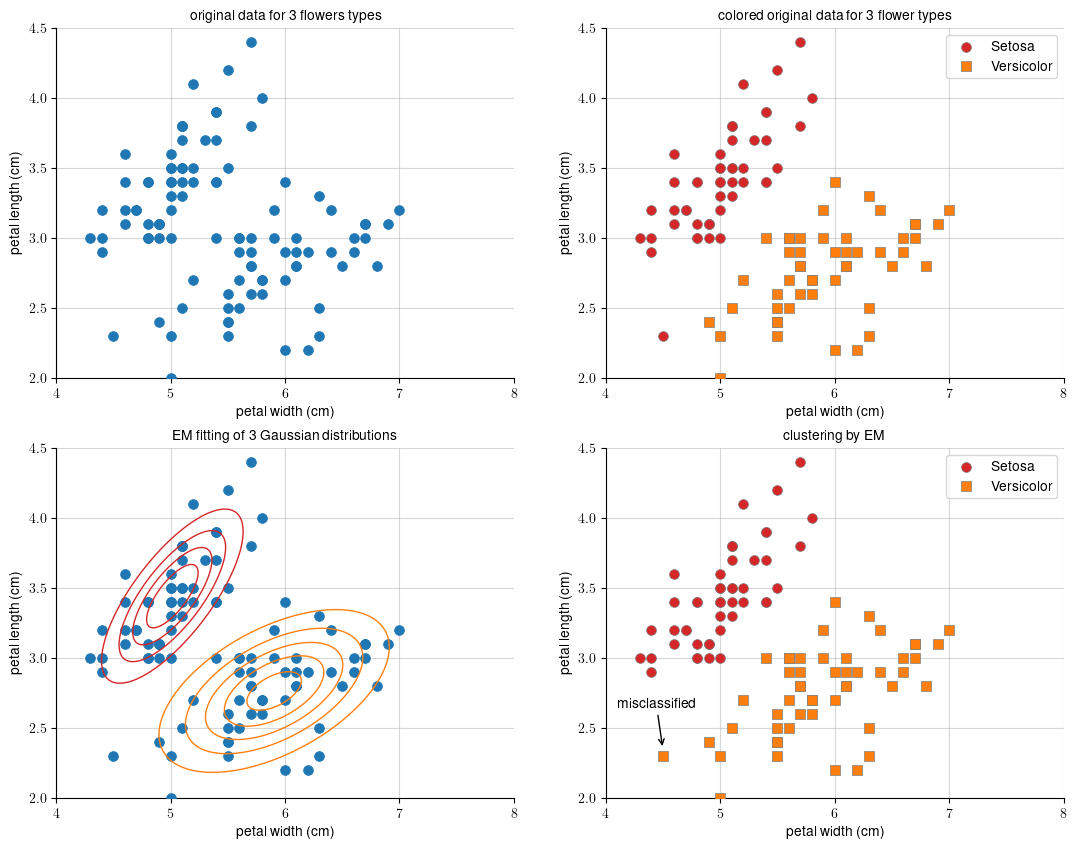

In [188]:
[T1, H1] = np.meshgrid(np.arange(4, 8, 0.02), np.arange(2, 4.5, 0.02))
[T2, H2] = np.meshgrid(np.arange(4, 8, 0.02), np.arange(2, 4.5, 0.02))

pdf1 = stats.multivariate_normal(mu_hat[0], R_hat[0]).pdf(np.dstack((T1, H1))) 
pdf2 = stats.multivariate_normal(mu_hat[1], R_hat[1]).pdf(np.dstack((T2, H2)))


#figure 6 (clustering)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 10
fig = plt.figure()

ax = fig.add_subplot(221)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:blue", linewidth=0.5, s=50, zorder=3)

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("original data for 3 flowers types", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])

ax = fig.add_subplot(222)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:red", linewidth=0.5, s=50, zorder=3, marker="o", edgecolors="tab:gray")
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:orange", linewidth=0.5, s=50, zorder=3, marker="s", edgecolors="tab:gray")

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("colored original data for 3 flower types", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])
plt.legend()

ax = fig.add_subplot(223)
ax.scatter(features_0[:, 0], features_0[:, 1], label="Setosa", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.scatter(features_1[:, 0], features_1[:, 1], label="Versicolor", color="tab:blue", linewidth=0.5, s=50, zorder=3)
ax.contour(T1, H1, pdf1, zorder=3, levels=5, colors="tab:red", linewidths=1)
ax.contour(T2, H2, pdf2, zorder=3, levels=5, colors="tab:orange", linewidths=1)

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("EM fitting of 3 Gaussian distributions", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])

ax = fig.add_subplot(224)
ax.scatter(class_0_X[:, 0], class_0_X[:, 1], label="Setosa", color="tab:red", linewidth=0.5, s=50, zorder=3, marker="o", edgecolors="tab:gray")
ax.scatter(class_1_X[:, 0], class_1_X[:, 1], label="Versicolor", color="tab:orange", linewidth=0.5, s=50, zorder=3, marker="s", edgecolors="tab:gray")

ax.set_xlabel("petal width (cm)", fontsize=10)
ax.set_ylabel("petal length (cm)", fontsize=10)
ax.set_title("clustering by EM", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.spines[['right', 'top']].set_visible(False)
plt.xticks(np.arange(4, 9, 1))
ax.set_ylim([2, 4.5])
ax.annotate("misclassified", xy=(4.5, 2.35), xytext=(4.1, 2.65), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=10, fontweight='bold')

plt.legend()

plt.show()

**Figure 32.8** ($\textit{Top left}$) Scatter diagram for $N=100$ petal length $\times$ petal width measurements for two flower types: setosa and versicolor. ($\textit{Top right}$) The same scatter diagram albeit with color and marker groupings to
specify which measurements arise from which flower type. ($\textit{Bottom left}$)  Gaussian level sets obtained from running $M=150$ iterations of the EM procedure (32.67). ($\textit{Bottom right}$)  Clustering result from the EM procedure where each data point is assigned to the most likely Gaussian component.

We repeat the same experiment by focusing exclusively on the data arising from the setosa and versicolor flowers. That is, we now have $N=100$ data points and use the EM procedure to fit $K=2$ Gaussian components. The result is shown in Fig 32.8. It is seen from the clustering result in the bottom right plot that the EM procedure is now almost entirely successful in clustering the data points correctly (with the exception of one setosa data point assigned erroneously to the versicolor class). In this case, the mean and covariance values obtained by the EM procedure are

$
\widehat{\mu_1} = 
\begin{bmatrix}
5.0158 \\ 3.4407
\end{bmatrix} \;\;\;
\widehat{\mu_2} = 
\begin{bmatrix}
5.9050 \\ 2.7634
\end{bmatrix} \;\;\;
$

$
\widehat{R_1} = 
\begin{bmatrix}
0.1196 & 0.0894 \\ 0.0894 & 0.1210
\end{bmatrix} \;\;\;
\widehat{R_2} = 
\begin{bmatrix}
0.2964 & 0.0919 \\ 0.0919 & 0.0990
\end{bmatrix} \;\;\;
$

The mixing probabilities are also estimated to be

$
\widehat{\pi}_1=0.4881,\;\;\;\widehat{\pi}_2=0.5119\;\;\;
$

## Example 32.8 (Image segmentation)

Besides clustering, another useful application of the EM procedure is image segmentation. The goal of image segmentation is to cluster pixels of similar properties into the same group, such as pixels of similar color. Image segmentation is relevant in many important applications, including object recognition, edge and boundary delineation, and image compression.

A color image with $R$ rows and $C$ columns is described by three $R\times C$ matrices (also called channels), one for each of the RGB colors: red, green, and blue. In other words, the image is described by a three-dimensional array of size $R\times C\times 3$, which is also called a {\em tensor}.\is{tensor} The array consists of three matrices, each containing the pixel intensities for one of the fundamental colors (red, green, and blue).  The intensities in this example vary from $0$ to $255$. We normalize them to the range $[0,1]$ by dividing by $255$. The image has $R=332$ rows and $C=539$ columns for a total of 

$
N=R\times C = 178,948\;\;\textnormal{pixels}
$

Each pixel in the image is represented by a $3\times 1$ vector containing its RGB intensities:

$
y_n=
\begin{bmatrix}
R \\ G \\ B
\end{bmatrix}
$

In this way, the input to the EM algorithm (32.67) will be a collection of $N=178,948$ vectors $\{y_n\}$ of size $3\times 1$ each.

In [ ]:
## Reading Image and transforming it into a collection of 3x1 vector
img = cv2.imread("data/royce.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_norm  = img /255

[R, C, P] = img.shape
N = R*C

n = 0
vec_image = np.zeros((3, N))
for r in range(R):
    for c in range(C):
        for p in range(P):
            vec_image[p, n] = img_norm[r, c, p] #vec_image is 3XN
        n += 1

K = 4 # number of Gaussian components
M = 30 #number of EM itearations

# Running the EM algorithm
# The most important output below for our purposes is the vector IND
# it is 1XN and contains the indexes of the most likely components for pixel

api_hat, alkd, aind, ar_hat, amu_hat, aR_hat = EM_GMM(vec_image, K, M)

# we now run over the image and all pixls belonging to the same component 
# are replaced by their average pixel color

new_image = np.zeros((P, N))
for n in range(N):
    for k in range(K):
        if aind[n] == k:
            new_image[:, n] = amu_hat[: , k]

new_image_un = np.floor(new_image*255) # in vector form and unormalized

# reconstruct the image from the vector with averaged colors.
n = 0
segmented_image = np.zeros(img_norm.shape)
for r in range(R):
    for c in range(C):
        for p in range(P):
            segmented_image[r, c, p] = new_image_un[p, n]
        n += 1

segmented_image = segmented_image.astype(np.uint8)
seg_image = cv2.medianBlur(segmented_image, 3) #median filtering

#looking for edges: adjacent pixels with different values

edges = np.zeros((R, C))
for r in range(R): #checking row-wise
    for c in range(C-1): 
        if seg_image[r, c, 0] != seg_image[r, c+1, 0]: #enough to check one layer
            edges[r, c] = 1
            edges[r, c+1] = 1

for c in range(C): #checking col-wise
    for r in range(R-1): 
        if seg_image[r, c, 0] != seg_image[r+1, c, 0]: #enough to check one layer
            edges[r, c] = 1
            edges[r+1, c] = 1

edge_image = np.copy(seg_image)
for r in range(R):
    for c in range(C):
        if edges[r, c] == 1:
            edge_image[r, c, 0] = 255 #red color edges
            edge_image[r, c, 1] = 0
            edge_image[r, c, 2] = 0

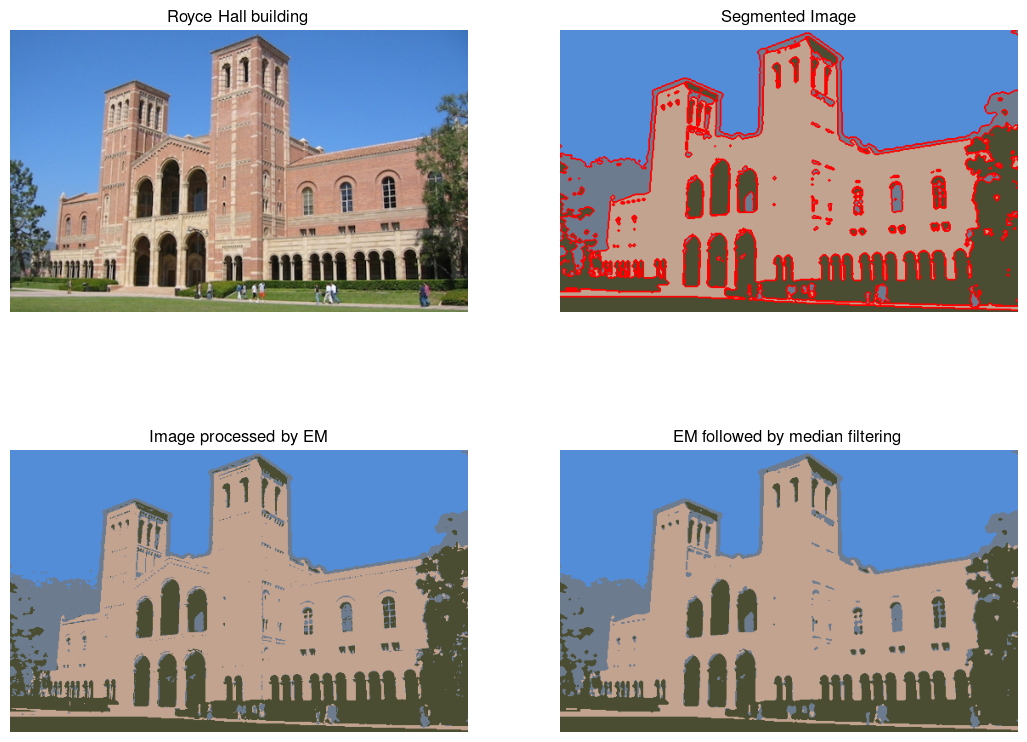

In [133]:
#figure 9 (image segmentation)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 10
fig = plt.figure()

ax = fig.add_subplot(221)
ax.imshow(img_norm)
ax.set_title("Royce Hall building")
plt.axis('off')

ax = fig.add_subplot(222)
ax.imshow(edge_image)
ax.set_title("Segmented Image")
plt.axis('off')

ax = fig.add_subplot(223)
ax.imshow(segmented_image)
ax.set_title("Image processed by EM")
plt.axis('off')

ax = fig.add_subplot(224)
ax.imshow(seg_image)
ax.set_title("EM followed by median filtering")
plt.axis('off')

plt.savefig("figs/fig-9.pdf", format="pdf", bbox_inches="tight")

plt.show()

**Figure 32.9** ($\textit{Top left}$) Original image capturing the Royce Hall building on the campus of the University of California, Los Angeles, USA. ($\textit{Top right}$) Final segmented image where pixels of similar color in the original image are grouped together and boundaries between groups are colored in red. ($\textit{Bottom left}$)  The result of the original image after processing by the EM procedure (32.67) and replacing each pixel by the average color level for all pixels within the same group. ($\textit{Bottom right}$)  The result of applying a median filter to the EM image from the bottom left to remove outliers. The source for the Royce Hall image in the top left corner is Wikimedia Commons, where the image is available for use under the Creative Commons Attribution Share-Alike License. The other three images have been processed by the segmentation procedure under discussion.

We apply the EM procedure for $M=30$ iterations assuming $K=4$ Gaussian components of dimension $3\times 1$ each. The algorithm generates four mean vectors  and the corresponding covariance matrices:

$
\Bigl\{\widehat{\mu}_1,\widehat{\mu}_2,\widehat{\mu}{3},\widehat{\mu}_4\Bigr\},\;\;\;\;
\Bigl\{\widehat{R}_1,\widehat{R}_2,\widehat{R}{3},\widehat{R}_4\Bigr\}
$

as well as four mixing probabilities:

$
\Bigl\{\widehat{\pi}_1,\widehat{\pi}_2,\widehat{\pi}_{3},\widehat{\pi}_4\Bigr\}
$

It also generates a responsibility measure $\widehat{r}(k,n)$ for each pixel location and allows us to determine which Gaussian component the pixel belongs to. The algorithm also estimates the number of pixels, $\widehat{N}_k$, that belong to each cluster. The quantities $\widehat{r}(k,n)$ and $\widehat{N}_k$ refer to the values of the iterated quantities $r^{(m)}(k,y_n)$ and $N_k^{(m)}$ at the end of the EM procedure.

Once the clustering is completed, all pixels belonging to the same cluster $k$ are  replaced by the mean value $\widehat{\mu}_k$ for that cluster

$
\Bigl\{\textnormal{every } y_n\in  \textnormal{ cluster } k \textnormal{ is replaced by } \widehat{\mu}_k\Bigr\}
$

These values, which are in the range $[0,1]$, are then scaled up and rounded to integer values in the range $[0,255]$. In this way, pixels within the same cluster will be colored similarly. The result is the image shown in the bottom left plot of Fig. 32.9 We subsequently smooth the image by sliding a $3\times 3$ median filter over it. The filter slides over the image one location at a time and replaces the pixel at that location by the median of the values covered by the $3\times 3$ mask. This is achieved by first sorting the pixel values covered by the mask into increasing order and then selecting the middle value from this list as the output. For example, consider a $3\times 3$ mask whose top leftmost corner is placed at location $(1,1)$ of the image. The mask will cover nine pixel values whose row and column indices are:

$
\begin{array}{ccc} (1,1) & (1,2) & (1,3)\\
(2,1) & (2,2) & (2,3)\\
(3,1)& (3,2) & (3,3)
\end{array} = 
\begin{bmatrix}
1 & 3 & 5 \\
3 & 4 & 3 \\
3 & 3 & 3 \\
\end{bmatrix}
$

The pixel values at these locations, say, the numbers shown on the right, will be ordered and the middle value used to replace the $(1,1)$ location in the image:

$
\textnormal{median}\Bigl\{1,3,3,3,\fbox{3},3,3,4,5\Bigr\}\;=\;3
$

Note that when most of the pixel values under a mask assume the same value due to clustering, except perhaps for some outlier pixel values, the outlier values will be ignored by the mask since the output of the median filter will be the most repeated pixel value in the set. The edges in the figure are determined by scanning through the image and detecting adjacent pixels of different colors. These pixels are colored in red. The final segmented image is shown in the top right corner of Fig.~\ref{llaksasasxasxfigasasGM;;laslM-DD.label}. The implementation is not perfected but is only meant to illustrate the main concepts. In particular, observe how the tree on the left side of the image ends up blended with the building. 

## Example 32.10 (Numerical example for a Bernoulli mixture model)

Figure 32.11 illustrates the operation of this procedure on a numerical example. A total of $N=2000$ vector samples, $y_n$, of size $3\times 1$ each are generated according to the Bernoulli mixture model (32.94) and (32.98) with parameters

$
\pi_1=\frac{1}{3},\quad\quad \pi_2=\frac{2}{3},\quad\quad
p_1 =
\begin{bmatrix}
0.6 \\ 0.3 \\ 0.7
\end{bmatrix} \quad\quad
p_2 =
\begin{bmatrix}
0.2 \\ 0.8 \\ 0.4
\end{bmatrix}
$

Iterations (32.117) are repeated $M=100$ times, starting from the initial conditions

$
\pi_1^{(0)}=\frac{1}{2},\,\quad\quad \pi_2^{(0)}=\frac{1}{2}
$

and randomly generated $p_1^{(0)}$ and $p_2^{(0)}$. The figure shows the evolution of the parameter iterates for the first 30 iterations with their values converging towards:

$
\pi_1^{(m)}\rightarrow 0.3594,\;\;\;\pi_2^{(m)}\rightarrow 0.6406,\;\;\;
p_1^{(m)}\rightarrow 
\begin{bmatrix}
0.5904 \\ 0.3615 \\ 0.7090
\end{bmatrix} \;\;\;
p_2^{(m)}\rightarrow 
\begin{bmatrix}
0.1925 \\ 0.7775 \\ 0.4077
\end{bmatrix}
$

In [14]:
K = 2 # two components
p1 = np.array([
    0.6, 0.3, 0.7
])

p2 = np.array([
    0.2, 0.8, 0.4
])

p1_1 = 1/3
pi_2 = 2/3

N = 2000

X = np.zeros((3, N))
X1 = np.zeros((3, N))
X2 = np.zeros((3, N))
y1 = np.zeros(3)
y2 = np.zeros(3)
N1 = 0
N2 = 0
res1 = np.zeros((N))
r_hat = np.zeros((K, N))

for n in range(N):
    x = np.random.rand() # a random number between 0 and 1
    if x <= p1_1:
        k = 1
        x1 = np.random.rand(3) # random numbers between 0 and 1
        for m in range(3):
            if x1[m] <= p1[m]:
                y1[m] = 1
            else:
                y1[m] = 0
        res1[n] = 1 #which component
        X1[:, N1] = y1
        X[:, n] = y1
        N1 += 1
    else:
        x2 = np.random.rand(3) # random numbers between 0 and 1
        for m in range(3):
            if x2[m] <= p2[m]:
                y2[m] = 1
            else:
                y2[m] = 0
        res1[n] = 2 # which component
        X[:, n] = y2
        X2[:, N2] = y2
        N2 += 1

# Running EM

pi_hat = np.zeros(2)
pi_hat[0] = 1/2
pi_hat[1] = 1/2

p_hat = np.zeros((2, 3))
p_hat[0] = np.random.rand(3)
p_hat[1] = np.random.rand(3)

M = 100 #number of iterations
N_hat = np.zeros(2)
pi_evolve = np.zeros((2, M))
p1_evolve = np.zeros((3, M))
p2_evolve = np.zeros((3, M))

for m in range(M):
    #E-step
    for k in range(K):
        p_hat_k = p_hat[k]
        pi_hat_k = pi_hat[k]

        for n in range(N):
            y = X[:, n]
            a = pi_hat_k*vector_bernoulli(y, p_hat_k)
            d = pi_hat[0]*vector_bernoulli(y, p_hat[0]) + pi_hat[1]*vector_bernoulli(y, p_hat[1])
            r_hat[k, n] = a/d
        N_hat[k] = r_hat[k, :].sum()

    #M_step

    z1 = r_hat[0]@X.T
    z2 = r_hat[1]@X.T

    p_hat[0] = z1/N_hat[0]
    p_hat[1] = z2/N_hat[1]
    pi_hat[0] = N_hat[0]/N
    pi_hat[1] = N_hat[1]/N

    pi_evolve[:, m] = pi_hat
    p1_evolve[:, m] = p_hat[0]
    p2_evolve[:, m] = p_hat[1]
        

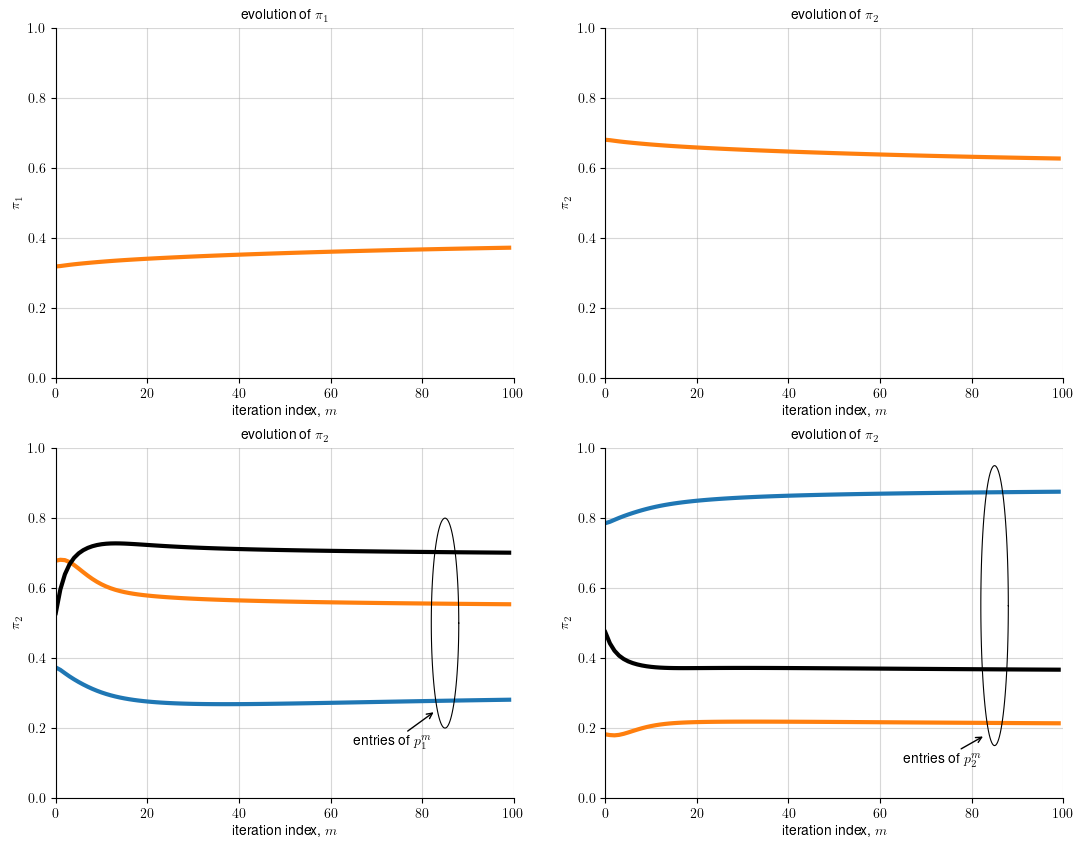

In [37]:
#figure 11 (evolution of parameters in Bernoulli mixture model)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.rcParams['figure.figsize']=13, 10
fig = plt.figure()

ax = fig.add_subplot(221)

ax.plot(np.arange(0, M, 1), pi_evolve[0], linewidth=3, color="tab:orange")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("$\pi_1$", fontsize=10)
ax.set_title("evolution of $\pi_1$", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylim([0, 1])
ax.set_xlim([0, M])
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(222)

ax.plot(np.arange(0, M, 1), pi_evolve[1], linewidth=3, color="tab:orange")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("$\pi_2$", fontsize=10)
ax.set_title("evolution of $\pi_2$", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylim([0, 1])
ax.set_xlim([0, M])
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(223)

ax.plot(np.arange(0, M, 1), p1_evolve[0], linewidth=3, color="tab:orange", label="$p^{(m)}_1(1)$")
ax.plot(np.arange(0, M, 1), p1_evolve[1], linewidth=3, color="tab:blue", label="$p^{(m)}_1(2)$")
ax.plot(np.arange(0, M, 1), p1_evolve[2], linewidth=3, color="black", label="$p^{(m)}_1(2)$")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("$\pi_2$", fontsize=10)
ax.set_title("evolution of $\pi_2$", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylim([0, 1])
ax.set_xlim([0, M])
ax.spines[['right', 'top']].set_visible(False)

#Plot the elipse
u = 85
v = 0.5
a = 3
b = 0.3
t = np.linspace(0, 2*np.pi, 100)
ax.plot( u+a*np.cos(t) , v+b*np.sin(t), color="black", linewidth=0.8)

ax.annotate("entries of $p^{m}_{1}$", xy=(83, 0.25), xytext=(65, 0.15), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=10, fontweight='bold')

ax = fig.add_subplot(224)

ax.plot(np.arange(0, M, 1), p2_evolve[0], linewidth=3, color="tab:orange", label="$p^{(m)}_2(1)$")
ax.plot(np.arange(0, M, 1), p2_evolve[1], linewidth=3, color="tab:blue", label="$p^{(m)}_2(2)$")
ax.plot(np.arange(0, M, 1), p2_evolve[2], linewidth=3, color="black", label="$p^{(m)}_2(3)$")
ax.set_xlabel("iteration index, $m$", fontsize=10)
ax.set_ylabel("$\pi_2$", fontsize=10)
ax.set_title("evolution of $\pi_2$", fontsize=10)
plt.grid(zorder=0, alpha=0.5)
ax.set_ylim([0, 1])
ax.set_xlim([0, M])
ax.spines[['right', 'top']].set_visible(False)

#Plot the elipse
u = 85
v = 0.55
a = 3
b = 0.4
t = np.linspace(0, 2*np.pi, 100)
ax.plot( u+a*np.cos(t) , v+b*np.sin(t), color="black", linewidth=0.8)

ax.annotate("entries of $p^{m}_{2}$", xy=(83, 0.18), xytext=(65, 0.1), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"), fontsize=10, fontweight='bold')

plt.show()

**Figure 32.11** Evolution of the iterates $\{\pi_1^{(m)},\pi_2^{(m)},p_1^{(m)},p_2^{(m)}\}$ towards their steady-state values for increasing values of the iteration index, $m$.